### Import

In [3750]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility
import ta.volume

#### Ignore warnings

In [3751]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [3752]:
# df = pd.read_csv("./data/nasdaq/csv/TXN.csv", sep=',')
df = pd.read_csv("./data/nasdaq/csv/INTC.csv", sep=',')
# df = pd.read_csv("./data/nyse/csv/X.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [3753]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

### EMA RSI

In [3754]:
df['EMA7_RSI14'] = ta.trend.EMAIndicator(df['RSI14'], window=7).ema_indicator()
df['EMA7_RSI30'] = ta.trend.EMAIndicator(df['RSI30'], window=7).ema_indicator()

#### SMA - Simple Moving Average

In [3755]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['SMA14'] = ta.trend.SMAIndicator(df['Close'], window=14).sma_indicator()
df['SMA30'] = ta.trend.SMAIndicator(df['Close'], window=30).sma_indicator()
df['SMA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()

#### EMA - Exponential Moving Average

In [3756]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=14).ema_indicator()
# df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### KAMA - Kaufman's Adaptive Moving Average

In [3757]:
# df['KAMA'] = ta.momentum.KAMAIndicator(close=df['Close']).kama()

### ADX - Average Directional Movement

In [3758]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### EMA ADX

In [3759]:
df['EMA7_ADX'] = ta.trend.EMAIndicator(df['ADX'], window=7).ema_indicator()

### Bollinger Bands

In [3760]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [3761]:
#consecutive days above sma20
df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
df['DASMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['AboveSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DASMA'] = r
df.drop(['AboveSMA20'], axis=1, inplace=True)

In [3762]:
#consecutive days above sma20
df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
df['DBSMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['BelowSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DBSMA'] = r
df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [3763]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

### Stochastic Oscillator

In [3764]:
df['SO'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()

### On Balance Volume

In [3765]:
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

### Chaikin Money Flow

In [3766]:
df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).chaikin_money_flow()

### Visualize

In [3767]:
start = 2000
# vdf = df
vdf = df[start:start+250]

fig = make_subplots(rows=8, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA10, name='SMA10'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA14, name='SMA14'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA50, name='SMA50'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA14, name='EMA14'), row=3, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.KAMA, name='KAMA'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=7, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=8, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=8, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [3768]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df

In [3769]:
def calc_trend_sma_ema(df, n=10, sma_threshold=0.01, ema_threshold=0.01):
	trend = []
	df['BBBandwidth_Q1'] = df['BBBandWidth'].rolling(window=50, min_periods=50).quantile(0.25)
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_sma10 = df['SMA10'].iloc[i + n]
		current_sma10 = df['SMA10'].iloc[i]
		future_ema14 = df['EMA14'].iloc[i + n]
		current_ema14 = df['EMA14'].iloc[i]
		# future_kama = df['KAMA'].iloc[i + n]
		# current_kama = df['KAMA'].iloc[i]

		future_sma30 = df['SMA30'].iloc[i + n]

		# future_ema_rsi

		future_bandwidth = df['BBBandWidth'].iloc[i + n]
		future_bandwidth_q1 = df['BBBandwidth_Q1'].iloc[i + n]

		future_pb = df['%B'].iloc[i + n]

		if (future_sma10 > current_sma10 * (1 + sma_threshold)) and (future_ema14 > current_ema14 * (1 + ema_threshold)) and (future_pb >= 0.6):
			trend.append('Up')
		elif (future_sma10 < current_sma10 * (1 - sma_threshold)) and (future_ema14 < current_ema14 * (1 - ema_threshold)) and (future_pb <= 0.4):
			trend.append('Down')
		elif (abs(future_sma10 - future_sma30) / future_sma30 < 0.02) and (future_bandwidth < future_bandwidth_q1) and (0.3 <= future_pb) and (future_pb <= 0.7):
			trend.append('Neutral')
		else:
			trend.append('Unknown')
	assert(len(trend) == len(df))
	# df.drop(['BBBandWidth_Q1'], axis=1, inplace=True)
	df['Trend'] = trend
	return df
		

In [3770]:
df = calc_trend_sma_ema(df, n=7, sma_threshold=0.01, ema_threshold=0.02)

#### Delete invalid data

In [3771]:
df = df[200:-100]
df = df[df['Trend'] != 'Unknown']
df.index = range(len(df))

In [3772]:
# df[5000:5010]

#### Indicator Analysis

In [3773]:
sma_threshold = 5
print(len(df[df['DASMA'] >= sma_threshold]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

2841
317
349
2175


In [3774]:
print(len(df[df['DBSMA'] >= sma_threshold]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

2190
1508
305
377


In [3775]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))


997
19
23
955


In [3776]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

534
507
8
19


In [3777]:
print(len(df[df['EMA7_RSI14'] < lower_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

266
246
3
17


In [3778]:
upper_rsi_threshold = 70
print(len(df[df['EMA7_RSI14'] > upper_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

640
15
26
599


In [3779]:
df[:5] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,CMF,BBBandwidth_Q1,Trend
0,1980-10-03,0.467448,0.467448,5068800.0,0.484375,0.483073,0.294327,70.900603,61.044517,59.464730,...,1,0,0.000221,0.000135,0.000087,69.696768,349872000.0,-0.357074,0.062987,Up
1,1980-10-04,0.483073,0.483073,6732800.0,0.494792,0.493056,0.300409,77.268380,65.955386,62.205208,...,2,0,0.002192,0.000546,0.001646,95.833588,356604800.0,-0.288328,0.062987,Up
2,1980-10-05,0.493056,0.493056,8396800.0,0.505208,0.503038,0.306491,81.891482,70.024839,64.675735,...,3,0,0.004508,0.001339,0.003170,95.833588,365001600.0,-0.213468,0.062987,Up
3,1980-10-06,0.503038,0.503038,10060800.0,0.515625,0.513021,0.312573,85.364180,73.443410,66.913101,...,4,0,0.007068,0.002484,0.004583,95.833588,375062400.0,-0.222327,0.062987,Up
4,1980-10-19,0.501736,0.503472,6656000.0,0.505208,0.501736,0.305698,51.301687,57.527155,59.387758,...,17,0,0.008232,0.008728,-0.000496,22.221137,341616000.0,-0.360838,0.062987,Down


In [3780]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,CMF,BBBandwidth_Q1,Trend
7578,2022-08-30,32.150002,32.939999,40182500.0,33.070000,32.259998,32.259998,21.647934,28.454949,34.599931,...,0,12,-1.013638,-0.844652,-0.168987,2.631502,3.420060e+10,-0.231259,0.082045,Down
7579,2022-08-31,31.770000,32.259998,44074500.0,32.389999,31.920000,31.920000,19.307449,26.922302,33.741196,...,0,13,-1.085430,-0.892807,-0.192622,3.289464,3.415652e+10,-0.234457,0.085646,Down
7580,2022-09-01,31.129999,31.920000,36440700.0,31.920000,31.760000,31.760000,18.225614,26.206936,33.338391,...,0,14,-1.142070,-0.942660,-0.199410,12.426053,3.412008e+10,-0.251998,0.091904,Down
7581,2022-09-02,31.059999,31.760000,34893300.0,32.380001,31.219999,31.219999,14.931359,23.898847,32.004433,...,0,15,-1.216509,-0.997430,-0.219079,3.443325,3.408519e+10,-0.329106,0.094999,Down
7582,2022-09-03,30.877500,31.219999,37917375.0,32.132501,31.005000,31.005000,13.774842,23.029200,31.485543,...,0,16,-1.278117,-1.053567,-0.224550,2.829666,3.404727e+10,-0.400785,0.103186,Down


#### Rolling Normalize

In [3781]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [3782]:
print(df['Trend'].value_counts())


Trend
Up         3610
Down       2714
Neutral    1259
Name: count, dtype: int64


In [3783]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)
df.drop(['EMA14'], axis=1, inplace=True)
df.drop(['SMA10'], axis=1, inplace=True)
df.drop(['SMA14'], axis=1, inplace=True)
df.drop(['SMA30'], axis=1, inplace=True)
df.drop(['SMA50'], axis=1, inplace=True)
df.drop(['BBBandwidth_Q1'], axis=1, inplace=True)
# df.drop(['KAMA'], axis=1, inplace=True)

### Train Model

In [3784]:
test_size = 0.25
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [3785]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5688 entries, 0 to 5687
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   RSI7         5688 non-null   float64
 1   RSI14        5688 non-null   float64
 2   RSI30        5688 non-null   float64
 3   RSI50        5688 non-null   float64
 4   EMA7_RSI14   5688 non-null   float64
 5   EMA7_RSI30   5688 non-null   float64
 6   ADX          5688 non-null   float64
 7   EMA7_ADX     5688 non-null   float64
 8   %B           5688 non-null   float64
 9   BBBandWidth  5688 non-null   float64
 10  DASMA        5688 non-null   int64  
 11  DBSMA        5688 non-null   int64  
 12  MACD         5688 non-null   float64
 13  MACD_signal  5688 non-null   float64
 14  MACD_hist    5688 non-null   float64
 15  SO           5688 non-null   float64
 16  OBV          5688 non-null   float64
 17  CMF          5688 non-null   float64
dtypes: float64(16), int64(2)
memory usage: 800.0 KB


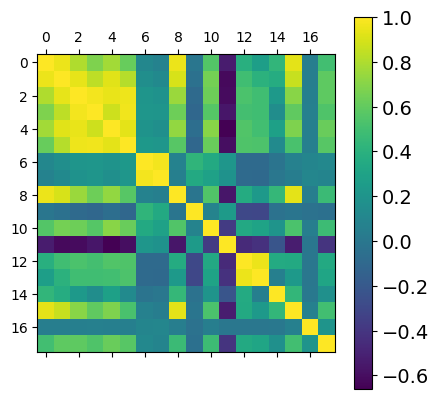

In [3786]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [3787]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

In [3788]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [3789]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([2835., 2835., 2835.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

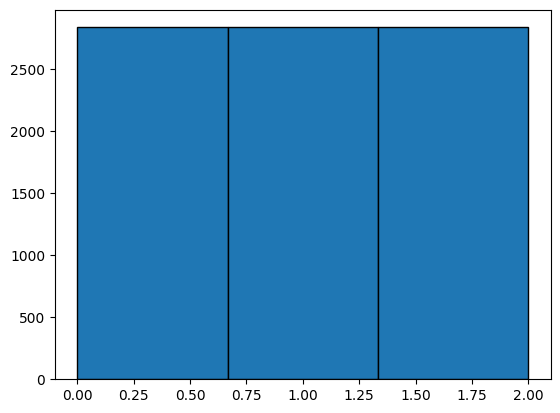

In [3790]:
plt.hist(y_train, bins=3, edgecolor='black')

(array([455., 455., 455.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

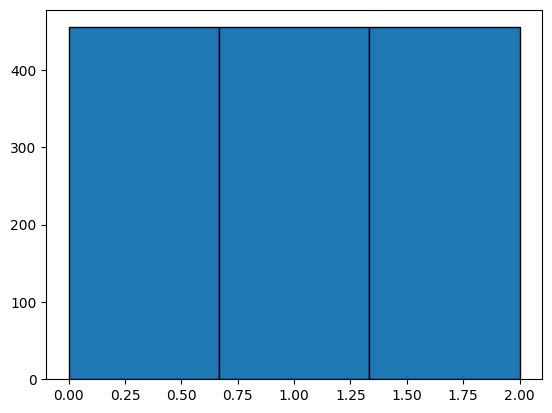

In [3791]:
plt.hist(y_test, bins=3, edgecolor='black')

In [3792]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [475],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 475, 'subsample': 0.6}
Best Cross-Validation Accuracy: 0.7235743680188125
CPU times: total: 28.9 s
Wall time: 38.4 s


In [3793]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.6322

Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.76      0.73       455
           1       0.61      0.33      0.43       455
           2       0.58      0.81      0.68       455

    accuracy                           0.63      1365
   macro avg       0.63      0.63      0.61      1365
weighted avg       0.63      0.63      0.61      1365


Confusion Matrix:
[[345  44  66]
 [108 149 198]
 [ 34  52 369]]


In [3794]:
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

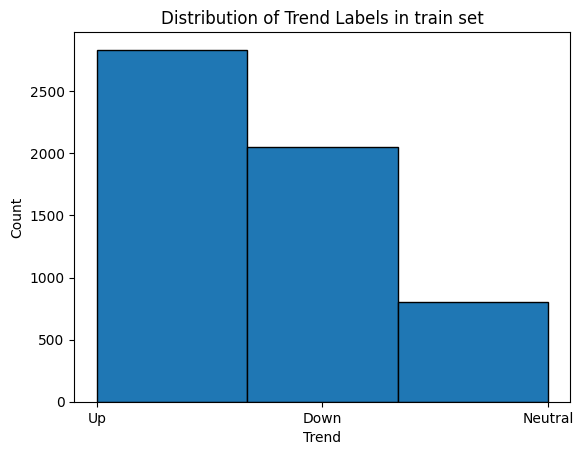

In [3795]:
plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

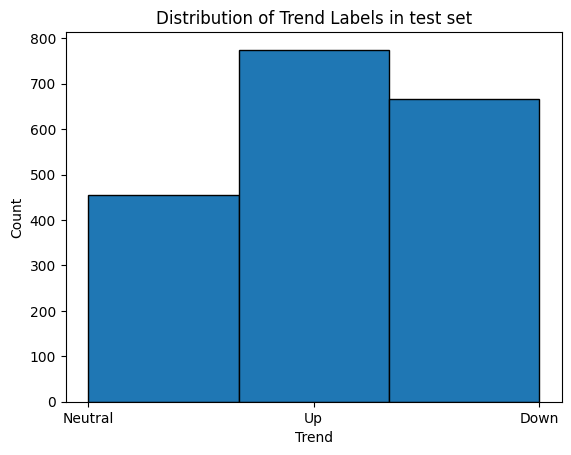

In [3796]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

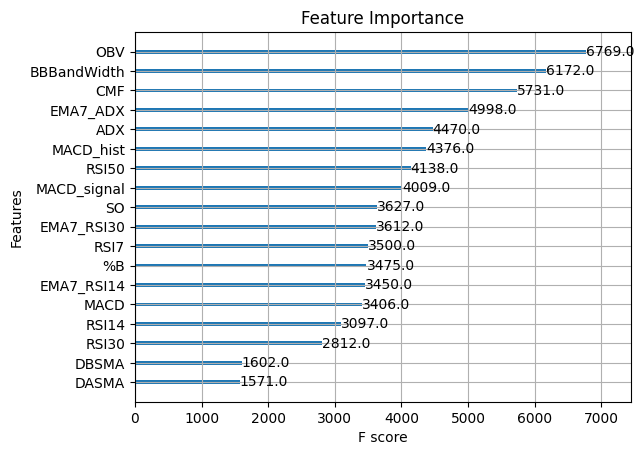

In [3797]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()